In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from numba import njit, objmode
from tqdm import tqdm


In [56]:
#Pauli matrices
I = np.eye(2)
X = np.array([[0,1],
              [1,0]])
Y = np.array([[0,-1j],
              [1j,0]])
Z = np.array([[1,0],
              [0,-1]])

def tensor_product(*args):
    """Compute the tensor product of multiple matrices."""
    result = args[0]
    for mat in args[1:]:
        result = np.kron(result, mat)
    return result   

def sigma_site(j, n, operator):
    """Return the operator for site j in a chain of n sites."""
    ops = [I] * n
    ops[j] = operator
    return tensor_product(*ops)


def creation_annihilation(j,n):


    f_dag = (sigma_site(j, n, X) + 1j * sigma_site(j, n, Y)) * 0.5
    f = (sigma_site(j, n, X) - 1j * sigma_site(j, n, Y)) * 0.5

    Zops = np.eye(2**n) 
    for i in range(0, j):
        Zops @= sigma_site(i, n, -Z)


    create = Zops @ f_dag 
    annihilate = Zops @ f 

    return create, annihilate


def majoranas(n):
    gammas = []
    for j in range(n):
        a_dag, a = creation_annihilation(j,n)

        gamma1 = a_dag + a
        gamma2 = 1j * (a_dag - a)

        gammas.append(gamma1)
        gammas.append(gamma2)
    gammas = np.array(gammas)
    return gammas

def delta(i,j):
    """Kronecker delta function."""
    return i == j

def braiding_operators(i,j):
    """
    Returns braiding operators for adjacent Majorana operators
    """
    return np.sqrt(1j/2) * (np.kron(I,I) - i@j)


def check_anti_commutation(gammas):
    """Check the anti-commutation relations of Majorana operators."""
    # n = len(gammas)'
    n = len(gammas) 
    for i in range(n):
        for j in range(n):
            result = gammas[i] @ gammas[j] + gammas[j] @ gammas[i]
            expected = 2 * delta(i, j) * np.eye(2**(n//2))
            assert np.allclose(result, expected), f"Anti-commutation failed for {i}, {j}. Expected:\n{expected},\ngot:\n{result}"
    
gammas = majoranas(3)
check_anti_commutation(gammas)

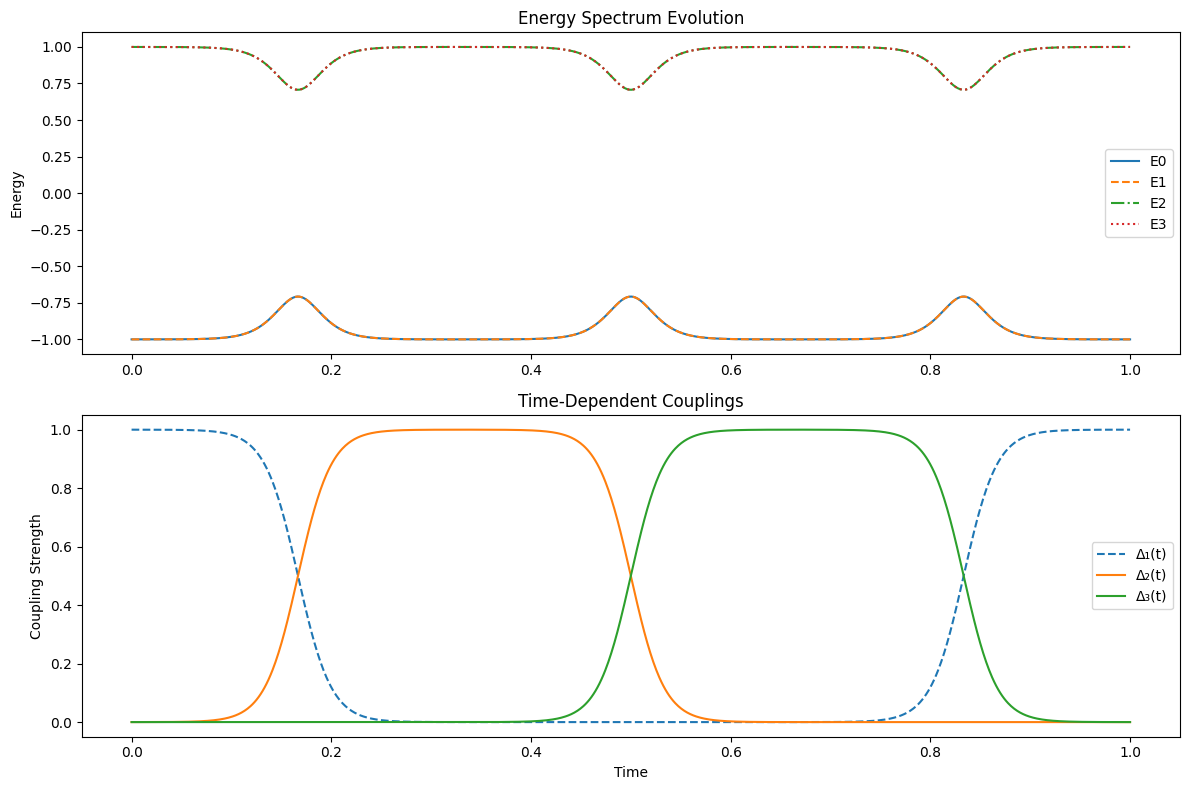

In [57]:

@njit
def delta_pulse(t, T_peak, width, s, Δ_max, Δ_min):
    """
    Improved smooth delta pulse with controllable width and steepness
    """
    # Calculate rise and fall times
    T_start = T_peak - width/2
    T_end = T_peak + width/2
    
    # Smooth step functions
    rise = 1/(1 + np.exp(-s*(t - T_start)))
    fall = 1/(1 + np.exp(s*(t - T_end)))
    
    return Δ_min + (Δ_max - Δ_min) * rise * fall

@njit
def build_hamiltonian(t, T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3):
    """
    Constructs the time-dependent Hamiltonian H(t) = Σ Δ_j(t) iγ₀γ_j
    """
    
    # Time-dependent couplings
    Δ1 = delta_pulse(t, 0, width, s, Δ_max, Δ_min) + delta_pulse(t, T_total, width, s, Δ_max, Δ_min) - Δ_min
    Δ2 = delta_pulse(t, T_total/3, width, s, Δ_max, Δ_min)
    Δ3 =  delta_pulse(t, 2*T_total/3, width, s, Δ_max, Δ_min)


    # Construct Hamiltonian terms
    H = (Δ1 * 1j * γ0 @ γ1 + 
         Δ2 * 1j * γ0 @ γ2 + 
         Δ3 * 1j * γ0 @ γ3)

    
    return H, (Δ1, Δ2, Δ3)


@njit
def analyze_spectrum(T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3, n_points=1000):
    times = np.linspace(0, T_total, n_points)
    energies = np.zeros((n_points, 4))  # Store all 4 eigenvalues
    couplings = np.zeros((n_points, 3))  # Store Δ1, Δ2, Δ3
    
    for i, t in enumerate(times):
        H, couplings[i] = build_hamiltonian(t, T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3)
        
        e_vals = np.linalg.eigvalsh(H)
        energies[i] = e_vals
    
    return times, energies, couplings

def plot_results(times, energies, couplings):
    plt.figure(figsize=(12, 8))
    
    # Plot energy spectrum
    plt.subplot(2, 1, 1)
    linestyles = ['-', '--', '-.', ':']
    for i in range(4):
        plt.plot(times, energies[:, i], label=f'E{i}', linestyle=linestyles[i])
    plt.ylabel('Energy')
    plt.title('Energy Spectrum Evolution')
    plt.legend()
    
    # Plot couplings
    plt.subplot(2, 1, 2)
    labels = ['Δ₁(t)', 'Δ₂(t)', 'Δ₃(t)']
    linestyles = ['--', '-', '-']
    for i in range(3):
        plt.plot(times, couplings[:, i], label=labels[i], linestyle=linestyles[i])
    # for i in range(3):
    #     plt.plot(times, couplings[:, i], label=labels[i])
    plt.xlabel('Time')
    plt.ylabel('Coupling Strength')
    plt.title('Time-Dependent Couplings')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

γ0, γ1, γ2, γ3 = majoranas(2)


T_total = 1.0
Δ_max = 1.0
Δ_min = 0
s = 60.0
width = T_total/3
# Parameters
params = {
    'T_total': T_total,
    'Δ_max': Δ_max,
    'Δ_min': Δ_min,
    's': s,
    'width': width,
    'γ0': γ0,
    'γ1': γ1,
    'γ2': γ2,
    'γ3': γ3,
    'n_points': 1000
}


times, energies, couplings = analyze_spectrum(**params)

# Visualize
plot_results(times, energies, couplings)

In [58]:

@njit
def adiabaticity_parameter(H_curr,H_prev, ground_vec, excited_vec, ground_energy, excited_energy, dt):
    """
    Calculate the adiabaticity parameter for a given Hamiltonian
    """
    # Calculate the derivative of the Hamiltonian
    ΔH = (H_curr - H_prev) / dt
    
    # Calculate the overlap with the eigenvector
    overlap = np.abs(np.vdot(excited_vec, ΔH @ ground_vec))
    ΔE = (excited_energy - ground_energy)**2 + 1e-10  # Avoid division by zero

    return overlap / ΔE
    
     

@njit
def evolve_wavefunction(ψ0 ,T_total, Δ_max, Δ_min, s, width,γ0,γ1,γ2,γ3, n_steps=1000):
    dt = T_total / n_steps
    times = np.linspace(0, T_total, n_steps)
    ψ = np.zeros((n_steps, 4), dtype=np.complex128)
    ψ[0] = ψ0

    couplings = np.zeros((n_steps, 3))  # Store Δ1, Δ2, Δ3

    norms = np.zeros(n_steps)
    norms[0] = np.linalg.norm(ψ0)


    evals = np.zeros((n_steps, 4))  # Store all 4 eigenvalues
    e_vecs = np.zeros((n_steps, 4, 4), dtype=np.complex128)  # Store eigenvectors

    ΔE = np.zeros((n_steps, 4), dtype=np.float64)  # Store derrivative of Hamiltonian
    ΔH = np.zeros((n_steps), dtype=np.float64)  # Store derrivative of Hamiltonian

    # Initial Hamiltonian
    H, couplings[0]  = build_hamiltonian(times[0], T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3)
    evals[0], e_vecs[0] = np.linalg.eigh(H)
    # ψ] = e_vecs[0,0] 

    for i in range(1, n_steps):
        H_i, couplings[i] = build_hamiltonian(times[i], T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3)
        evals[i], e_vecs[i] = np.linalg.eigh(H_i)

        # ΔE[i] = (evals[i] - evals[i-1]) / dt  # Calculate the derivative of the Hamiltonian
        ΔE[i] = adiabaticity_parameter(H_i, H, e_vecs[i,1], e_vecs[i,2], evals[i,1], evals[i,2], dt)
        ΔH[i] = np.sum(np.abs(H_i - H)) / np.abs(dt*evals[i, 0])  # Calculate the derivative of the Hamiltonian

        with objmode(tmp ='complex128[:,:]'):
            tmp = expm(-1j * H_i * dt)

        ψ[i] = tmp @ ψ[i-1]  # Time evolution using matrix exponential

        norm = np.linalg.norm(ψ[i]) 
        norms[i] = norm

        H = H_i  # Update Hamiltonian for the next step

    
    return times, ψ, norms, couplings, evals, e_vecs, ΔE, ΔH

def plot_evolution(times, ψ, norms, couplings,evals):
    plt.figure(figsize=(12, 12))
    
    # Plot wavefunction probabilities
    plt.subplot(4, 1, 1)
    plt.plot(times, np.abs(ψ[:, 0])**2, label=r'$|++⟩$',linestyle='-')
    plt.plot(times, np.abs(ψ[:, 1])**2, label=r'$|+-⟩$',linestyle='--')
    plt.plot(times, np.abs(ψ[:, 2])**2, label=r'$|-+⟩$',linestyle=':')
    plt.plot(times, np.abs(ψ[:, 3])**2, label=r'$|--⟩$',linestyle='-.')
    plt.ylabel('Probability')
    plt.title('Wavefunction Probabilities')
    plt.legend()
    
    # Plot norm
    plt.subplot(4, 1, 2)
    plt.plot(times, norms)
    plt.axhline(1, color='r', linestyle='--', label='Norm = 1')
    plt.ylabel('Norm')
    plt.ylim(0.5, 1.5)
    plt.title('Norm of the Wavefunction')
    plt.legend()
    
    # Plot couplings
    plt.subplot(4, 1, 3)
    labels = ['Δ₁(t)', 'Δ₂(t)', 'Δ₃(t)']
    linestyles = ['--', '-', '-']
    for i in range(3):
        plt.plot(times, couplings[:, i], label=labels[i], linestyle=linestyles[i])
    plt.xlabel('Time')
    plt.ylabel('Coupling Strength')
    plt.title('Time-Dependent Couplings')
    plt.legend()
    
    #plot evals
    plt.subplot(4, 1, 4)
    linestyles = ['-', '--', '-.', ':']
    plt.plot(times, evals[:, 0], label='E₀', color='blue', linestyle=linestyles[0])
    plt.plot(times, evals[:, 1], label='E₁', color='orange', linestyle=linestyles[1])
    plt.plot(times, evals[:, 2], label='E₂', color='green', linestyle=linestyles[2])
    plt.plot(times, evals[:, 3], label='E₃', color='red', linestyle=linestyles[3])
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title('Energy Spectrum Evolution')
    plt.legend()
    plt.tight_layout()
    plt.show()




T_total = 100
Δ_max = 100
Δ_min = 0.0

width = T_total/3
s = 20/width  # steepness parameter, controls the width of the pulse

ψ0= np.array([0,1,0,0],dtype=np.complex128)
ψ0/= np.linalg.norm(ψ0)  # Normalize the initial state

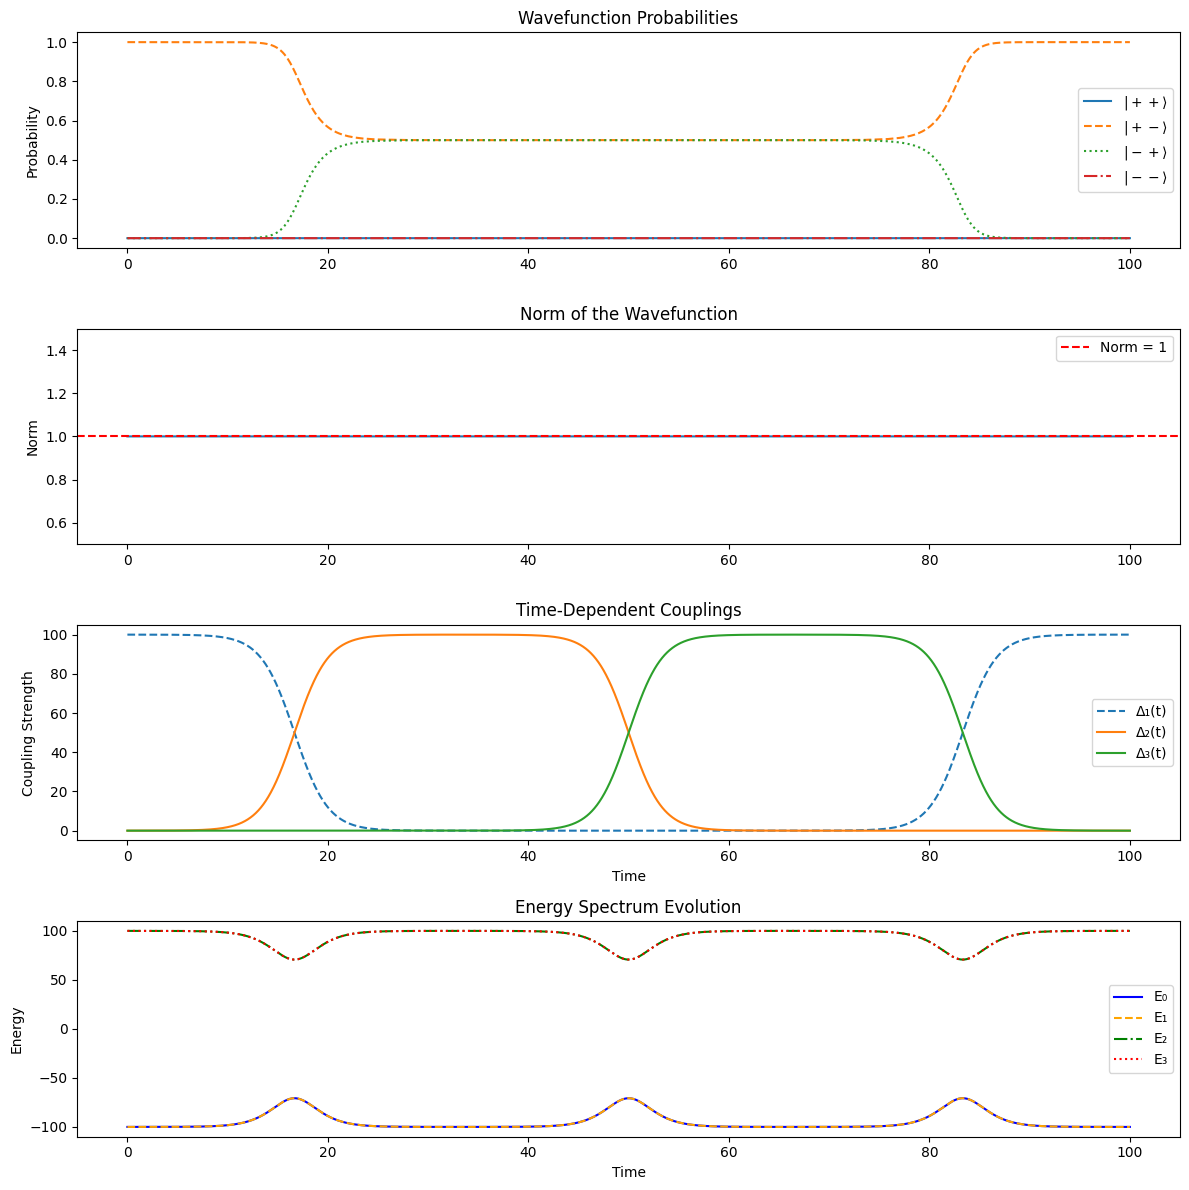

In [59]:
times, ψ, norms, couplings, evals, evecs, ΔE, ΔH  = evolve_wavefunction(ψ0, T_total, Δ_max, Δ_min, s, width, γ0, γ1, γ2, γ3, n_steps=4000)
plot_evolution(times, ψ, norms, couplings,evals)

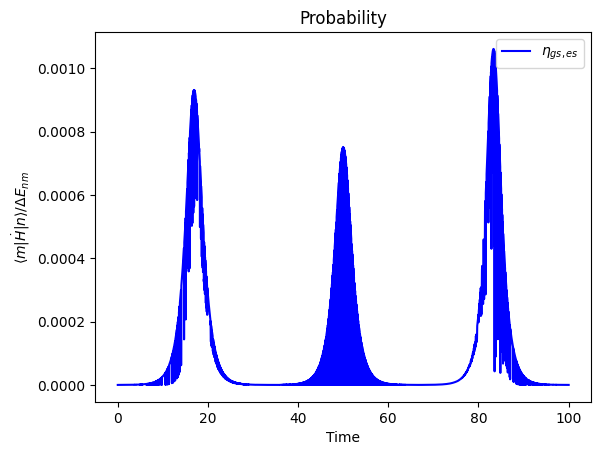

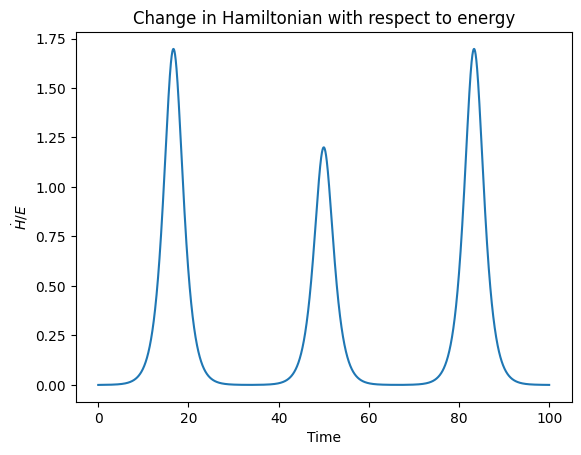

In [60]:
plt.plot(times, ΔE[:,0], label=r'$η_{gs,es}$', color='blue')
plt.ylabel(r'$⟨m|\dot{H}|n⟩/ΔE_{nm}$')
plt.xlabel('Time')
plt.title('Probability')
plt.legend()
plt.show()



plt.plot(times, ΔH)
plt.ylabel(r'$\dot{H}/E$')
plt.xlabel('Time')
plt.title('Change in Hamiltonian with respect to energy')
plt.show()



/tmp/ipykernel_26313/1466126454.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  Parities[i, 0] = (np.vdot(ψ[i], op1@ψ[i]))
/tmp/ipykernel_26313/1466126454.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  Parities[i, 1] = (np.vdot(ψ[i], op2@ψ[i]))
/tmp/ipykernel_26313/1466126454.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Parities[i, 2] = (np.vdot(ψ[i], op3@ψ[i]))


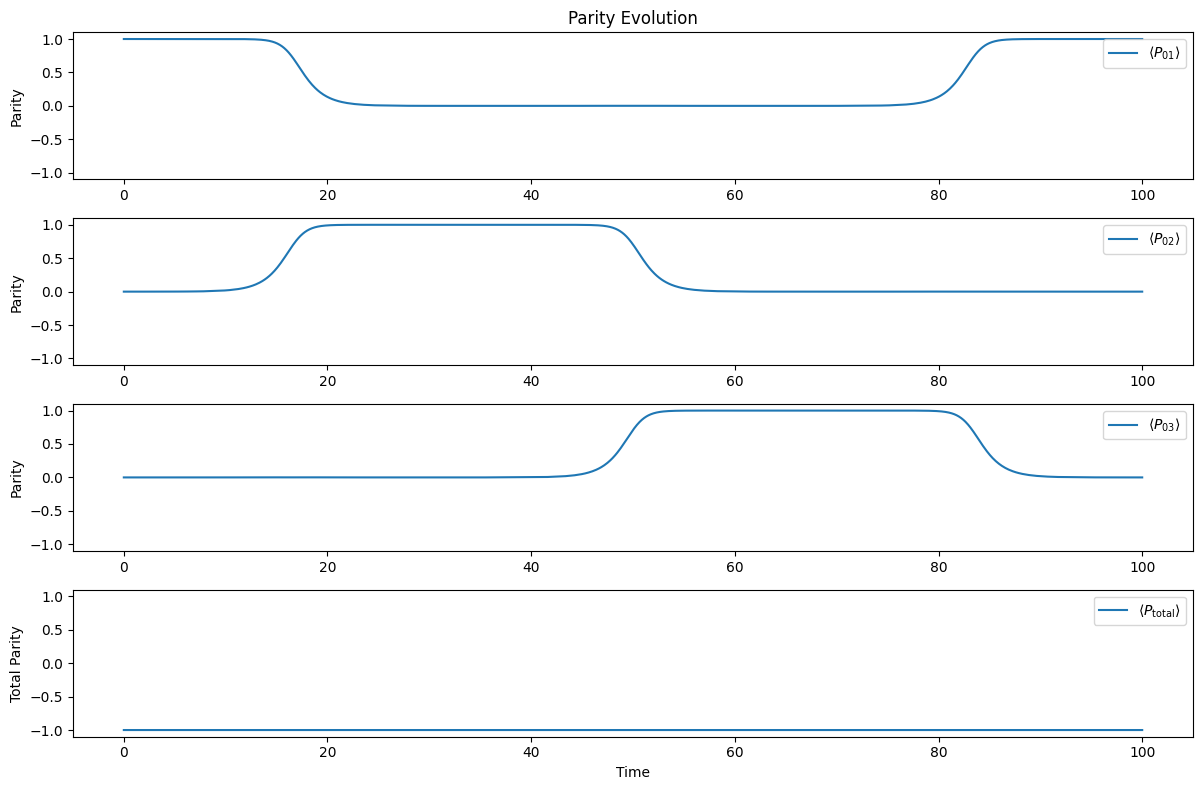

In [61]:


basis_parities = np.array([+1, -1, -1, +1])

Parities = np.zeros((ψ.shape[0], 4))
op1 = 1j * γ0 @ γ1
op2 = 1j * γ0 @ γ2
op3 = 1j * γ0 @ γ3

for i in range(ψ.shape[0]):
    Parities[i, 0] = (np.vdot(ψ[i], op1@ψ[i]))
    Parities[i, 1] = (np.vdot(ψ[i], op2@ψ[i]))
    Parities[i, 2] = (np.vdot(ψ[i], op3@ψ[i]))
    probs = np.abs(ψ[i])**2  # shape (4,)
    Parities[i, 3] = np.dot(probs, basis_parities)


plt.figure(figsize=(12, 8))

plt.subplot(4,1,1)
plt.ylabel('Parity')
plt.title('Parity Evolution')
plt.plot(times, Parities[:, 0], label=r'$⟨ P_{01} ⟩ $')
plt.ylim(-1.1, 1.1)
plt.legend()

plt.subplot(4,1,2)
plt.ylabel('Parity')
plt.plot(times, Parities[:, 1], label=r'$⟨ P_{02} ⟩ $')
plt.ylim(-1.1, 1.1)
plt.legend()

plt.subplot(4,1,3)
plt.plot(times, Parities[:, 2], label=r'$⟨ P_{03} ⟩ $')
plt.ylabel('Parity')
plt.ylim(-1.1, 1.1)
plt.legend()

plt.subplot(4,1,4)
plt.plot(times, Parities[:, 3], label=r'$⟨ P_\mathrm{total} ⟩$')
plt.ylabel('Total Parity')
plt.xlabel('Time')
plt.ylim(-1.1, 1.1)
plt.legend()

plt.tight_layout()
plt.show()

In [62]:

# @njit
# def berry_phase_kato(times, evecs):
#     n = len(times)
#     dt = times[1] - times[0]
    
#     U = np.eye(4, dtype=np.complex128)

#     for i in range(n - 1):
#         P = np.outer(evecs[i,0] ,evecs[i,0].conj() ) + np.outer(evecs[i,1] ,evecs[i,1].conj())
#         P_next = np.outer(evecs[i+1,0] ,evecs[i+1,0].conj() ) + np.outer(evecs[i+1,1] ,evecs[i+1,1].conj())
    
#         dPdt = (P_next - P) / dt
#         K = (P @ dPdt - dPdt @ P)
#         with objmode(tmp ='complex128[:,:]'):
#             tmp = expm(-dt * K)
        
#         U = tmp @ U
        
#     return U

# U = berry_phase_kato(times, evecs)

def orthonormalize(vs):
    """Orthonormalize columns of vs using QR decomposition."""
    q, _ = np.linalg.qr(vs)
    return q

@njit
def berry_phase_kato(times, evecs):
    n = len(times)
    dt = times[1] - times[0]
    
    U = np.eye(4, dtype=np.complex128)

    for i in range(n - 1):
        # Pull out the two eigenvectors at step i and i+1
        v1 = evecs[i, :, 0]
        v2 = evecs[i, :, 1]
        w1 = evecs[i+1, :, 0]
        w2 = evecs[i+1, :, 1]

        # Build orthonormal subspace basis
        V = np.column_stack((v1, v2))
        W = np.column_stack((w1, w2))

        # [Optional] Align gauge by maximizing overlap
        # Replace with actual QR or SVD if needed

        P = V @ V.conj().T
        P_next = W @ W.conj().T

        dPdt = (P_next - P) / dt
        K = P @ dPdt - dPdt @ P

        with objmode(tmp='complex128[:,:]'):
            tmp = expm(-dt * K)

        U = tmp @ U

    return U


In [63]:

### Fidelity
@njit
def fidelity(ψ0, ψT):
    """
    Computes the fidelity between two states
    """
    return np.abs(np.vdot(ψ0, ψT))**2


@njit
def compute_fidelity(Total, s, Δ_max, Δ_min, width, γ0, γ1, γ2, γ3, ψ0, Target_state,n_steps=1000):
    """
    Computes the fidelity for given T and s parameters
    """

    times, ψ, norms, couplings, evals, evecs, DE, DH = evolve_wavefunction(ψ0, T_total=Total, Δ_max=Δ_max, Δ_min=Δ_min, s=s, width=width, γ0=γ0, γ1=γ1, γ2=γ2, γ3=γ3, n_steps=1000)

    Fidelity_target = fidelity(ψ[-1], Target_state) 
    
    

    E1 = evals[:, 1]
    U_B = berry_phase_kato(times, evecs)
    U = np.exp(-1j * T_total * np.trapz(E1))*U_B

    Fidelity_Berry = fidelity(ψ[-1], U @ ψ0)


    return Fidelity_target, Fidelity_Berry, DE, DH

B23 = braiding_operators(γ2, γ3)
Target_state = B23 @ ψ0

Δ_max = 10
Width = T_total/3
T_vals = np.linspace(400, 3000, 20)
dmin_factor = np.linspace(0, 0.5, 20)


Fidelity_targets = []
Fidelity_Berry_targets = []

for T in tqdm(T_vals, desc="Calculating Fidelity and Berry Phase Error for different T_total"):
    for d in dmin_factor:
        Δ_min = d * Δ_max
        width = T/3
        s = 20/width

        Fidelity_target, Fidelity_Berry , ΔE, ΔH = compute_fidelity(T, s, Δ_max, Δ_min, Width, γ0, γ1, γ2, γ3, ψ0, Target_state,n_steps=1000)
        Fidelity_targets.append(Fidelity_target)
        Fidelity_Berry_targets.append(Fidelity_Berry)

Calculating Fidelity and Berry Phase Error for different T_total:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating Fidelity and Berry Phase Error for different T_total: 100%|██████████| 20/20 [02:13<00:00,  6.69s/it]


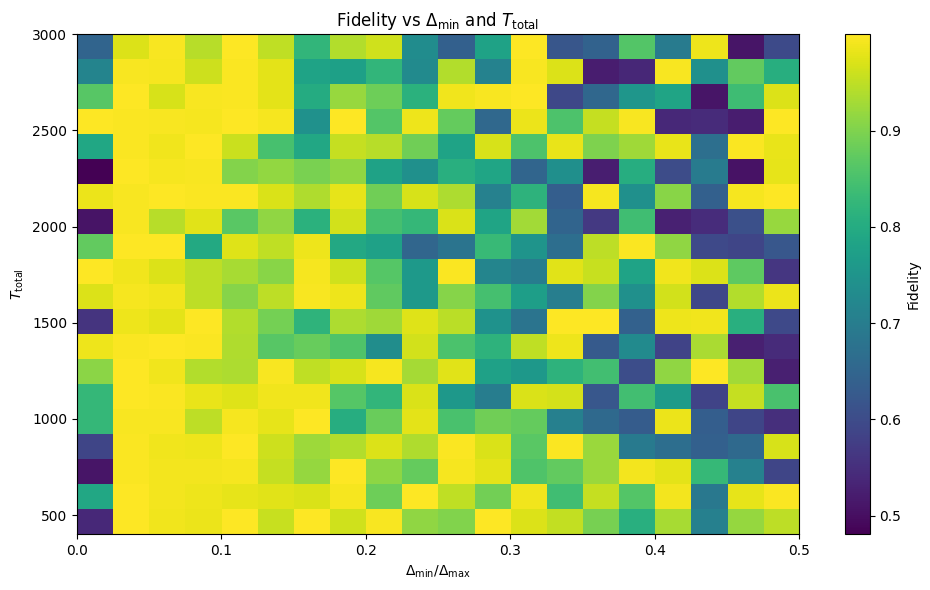

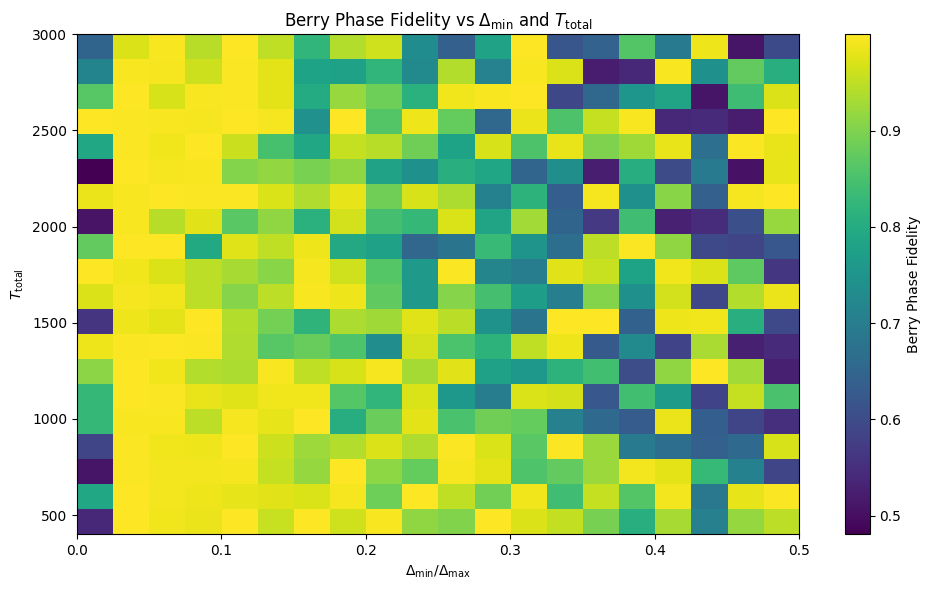

In [67]:
Fidelity_targets = np.array(Fidelity_targets).reshape(len(T_vals), len(dmin_factor))
Fidelity_Berry_targets = np.array(Fidelity_Berry_targets).reshape(len(T_vals), len(dmin_factor))
plt.figure(figsize=(10, 6))
plt.imshow(Fidelity_targets, extent=(dmin_factor[0], dmin_factor[-1], T_vals[0], T_vals[-1]), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Fidelity')
plt.xlabel(r'$Δ_{\text{min}}/Δ_{\text{max}}$')
plt.ylabel(r'$T_{\text{total}}$')
plt.title(r'Fidelity vs $Δ_{\text{min}}$ and $T_{\text{total}}$')
plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(Fidelity_Berry_targets, extent=(dmin_factor[0], dmin_factor[-1], T_vals[0], T_vals[-1]), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Berry Phase Fidelity')
plt.xlabel(r'$Δ_{\text{min}}/Δ_{\text{max}}$')
plt.ylabel(r'$T_{\text{total}}$')
plt.title(r'Berry Phase Fidelity vs $Δ_{\text{min}}$ and $T_{\text{total}}$')
plt.tight_layout()
plt.show()


In [65]:
#print best fidelity and fidelity
min_fidelity_idx = np.unravel_index(np.argmax(Fidelity_targets), Fidelity_targets.shape)
optimal_T = T_vals[min_fidelity_idx[0]]
optimal_dmin = dmin_factor[min_fidelity_idx[1]]
print(f"Optimal T_total: {optimal_T:.3f}, Optimal Δ_min/Δ_max: {optimal_dmin:.3f}")
print(f"Maximum Fidelity: {Fidelity_targets[min_fidelity_idx]:.3f}")
max_fidelity_idx = np.unravel_index(np.argmax(Fidelity_Berry_targets), Fidelity_Berry_targets.shape)
optimal_T_fidelity = T_vals[max_fidelity_idx[0]]
optimal_dmax_fidelity = dmin_factor[max_fidelity_idx[1]]
print(f"Optimal T_total for Maximum fidelity: {optimal_T_fidelity:.3f}, Optimal Δ_min/Δ_max for Maximum fidelity: {optimal_dmax_fidelity:.3f}")
print(f"Maximum Berry Phase fidelity: {Fidelity_Berry_targets[max_fidelity_idx]:.3f}")

Optimal T_total: 1494.737, Optimal Δ_min/Δ_max: 0.342
Maximum Fidelity: 1.000
Optimal T_total for Maximum fidelity: 1494.737, Optimal Δ_min/Δ_max for Maximum fidelity: 0.342
Maximum Berry Phase fidelity: 1.000


In [66]:
#Find the parameters where both fidelities are above 0.99
above_99 = np.where((Fidelity_targets > 0.999) & (Fidelity_Berry_targets > 0.999))
optimal_Ts = T_vals[above_99[0]]
optimal_dmins = dmin_factor[above_99[1]]
print(f"Parameters where both fidelities are above 0.99:")

for i in range(len(optimal_Ts)):
    T = optimal_Ts[i]
    dmin = optimal_dmins[i]
    fid = Fidelity_targets[above_99][i]
    berry_fid = Fidelity_Berry_targets[above_99][i]
    print(f"T_total: {T:.3f}, Δ_min/Δ_max: {dmin:.3f}, Fidelity: {fid:.4f}, Berry Phase Fidelity: {berry_fid:.4f}")


Parameters where both fidelities are above 0.99:
T_total: 400.000, Δ_min/Δ_max: 0.105, Fidelity: 0.9995, Berry Phase Fidelity: 0.9995
T_total: 400.000, Δ_min/Δ_max: 0.158, Fidelity: 1.0000, Berry Phase Fidelity: 1.0000
T_total: 400.000, Δ_min/Δ_max: 0.289, Fidelity: 0.9996, Berry Phase Fidelity: 0.9996
T_total: 536.842, Δ_min/Δ_max: 0.026, Fidelity: 0.9995, Berry Phase Fidelity: 0.9995
T_total: 536.842, Δ_min/Δ_max: 0.237, Fidelity: 0.9993, Berry Phase Fidelity: 0.9993
T_total: 673.684, Δ_min/Δ_max: 0.184, Fidelity: 0.9992, Berry Phase Fidelity: 0.9992
T_total: 810.526, Δ_min/Δ_max: 0.105, Fidelity: 0.9991, Berry Phase Fidelity: 0.9991
T_total: 947.368, Δ_min/Δ_max: 0.158, Fidelity: 0.9999, Berry Phase Fidelity: 0.9999
T_total: 1221.053, Δ_min/Δ_max: 0.026, Fidelity: 0.9994, Berry Phase Fidelity: 0.9994
T_total: 1494.737, Δ_min/Δ_max: 0.342, Fidelity: 1.0000, Berry Phase Fidelity: 1.0000
T_total: 1494.737, Δ_min/Δ_max: 0.368, Fidelity: 1.0000, Berry Phase Fidelity: 1.0000
T_total: 1768